In [1]:
import torch
import torchvision
from torchvision import transforms,models
from PIL import Image
import matplotlib.pyplot as plt
from torch.autograd import Variable
import copy
import cv2

In [2]:
%matplotlib inline

# 定义转化方式和输入函数

In [3]:
# 定义转化方式
transform = transforms.Compose([transforms.Resize([224,224]),transforms.ToTensor()])

In [4]:
# 读取图片
def loading(path = None):
  img = Image.open(path)
  img = transform(img)
  # 提高维度
  img = img.unsqueeze(0)
  return img

# 导入内容图和损失图

In [5]:
# 选择内容图片和风格图片
content_name = "1.jpg"
style_name = "2.jpg"
content_img = loading("./content/"+content_name)
content_img = Variable(content_img).cuda()
styple_img = loading("./style/"+style_name)
styple_img = Variable(styple_img).cuda()

# 定义损失值和格拉姆矩阵
* MSE:$\sum_{i=0}^n(yHat^i-y^i)^2$

In [6]:
# 图像内容损失
class Content_loss(torch.nn.Module):
    # target是通过卷积获取的输入图像中的内容，weight是我们设置的权重参数
    def __init__(self,weight,target):
        super(Content_loss,self).__init__()
        self.weight = weight
        # 用于对提取到的内容进行锁定，不需要进行梯度
        self.target = target.detach()*weight
        self.loss_fn = torch.nn.MSELoss()
        
    
    def forward(self,input):
        # input是卷积层中输入的图像
        self.loss = self.loss_fn(input*self.weight,self.target)
        return input
    
    def backward(self):
        # 保留计算图（中间变量保存下来，便于对style_loss进行计算）
        self.loss.backward(retain_graph=True)
        return self.loss

In [7]:
# 格拉姆矩阵的解析：https://www.cnblogs.com/yifanrensheng/p/12862174.html
# 作用：提取风格图片的风格
class Gram_matrix(torch.nn.Module):
    def forward(self,input):
        a,b,c,d = input.size()
        feature = input.view(a*b,c*d)
        gram = torch.mm(feature,feature.t())
        return gram.div(a*b*c*d)

In [8]:
# 图像风格损失
class Style_loss(torch.nn.Module):
    def __init__(self,weight,target):
        super(Style_loss,self).__init__()
        self.weight = weight
        self.target = target.detach()*weight
        self.loss_fn = torch.nn.MSELoss()
        self.gram = Gram_matrix()
    
    def forward(self,input):
        self.Gram = self.gram(input.clone())
        self.Gram.mul_(self.weight)
        self.loss = self.loss_fn(self.Gram,self.target)
        return input
    
    def backward(self):
        self.loss.backward(retain_graph=True)
        return self.loss

# 导入预置网络VGG16

In [9]:
# 导入特征提取网络
cnn = models.vgg16(pretrained=False)
pre = torch.load("./model/vgg16-397923af.pth")
cnn.load_state_dict(pre)
# 提取VGG16的features部分
cnn = cnn.features
cnn = cnn.cuda()


In [10]:
# 重新创建我们的模型
model = copy.deepcopy(cnn)

# 对迁移模型初始化

In [11]:
# 提取内容所需要的卷积层
content_layer = ["Conv_3"]
# 提取风格所需要的的卷积层
style_layer = ["Conv_1","Conv_2","Conv_3","Conv_4"]
# 定义内容和风格的损失值，用于控制内容和风格对最后合成图的影响程度
content_weight = 10
style_weight = 1000

In [12]:
# 存储每一个内容层和风格层的计算图列表
content_losses = []
style_losses = []

# 构建迁移模型

In [13]:
# 创建一个空模型，用来存储我们的迁移模型
new_model = torch.nn.Sequential()

gram = Gram_matrix()
new_model = new_model.cuda()
gram = gram.cuda()

In [14]:
# 构建迁移模型
index = 1
# 从VGG16中提取出前8层来当做风格迁移的特征提取层
for layer in list(model)[:8]:
  # 如果这一层是我们的Conv2d类型，就将它加入到我们的新模型中
  if isinstance(layer,torch.nn.Conv2d):
    name = "Conv_" +str(index)
    new_model.add_module(name,layer)
    # 根据选择的层数分配为风格提取和内容提取
    if name in content_layer:
        # 创建特征提取层，
        # 将内容图输入到模型中进行计算，获得卷积得到的feature map
      target = new_model(content_img).clone()
     # 将控制内容图的权重与feature map 构建内容损失函数对象
      content_loss = Content_loss(content_weight,target)
    # 将这个对象添加到模型中
      new_model.add_module("content_loss_"+str(index),content_loss)
    # 记录损失函数计算过程
      content_losses.append(content_loss)
    
    if name in style_layer:
    # 将内容图输入到模型中进行计算，获得卷积得到的feature map
      target = new_model(styple_img).clone()
    # 将这个feature map构建格拉姆矩阵
      target = gram(target)
    # 实例化风格损失函数
      style_loss = Style_loss(style_weight,target)
    # 讲风格损失函数对象添加到模型中
      new_model.add_module("style_loss_"+str(index),style_loss)
    # 记录损失函数计算过程
      style_losses.append(style_loss)

  if isinstance(layer,torch.nn.ReLU):
    # 激活函数正常激活即可
    name = "Relu_" + str(index)
    new_model.add_module(name,layer)
    index = index + 1


  if isinstance(layer,torch.nn.MaxPool2d):
    # 最大池化层也正常池化即可
    name = "MaxPool_"+str(index)
    new_model.add_module(name,layer)

# 开始训练

In [15]:
# 获取输入图片，避免在卷积过程中对原图产生影响因此使用了clone
input_img = content_img.clone()
# 将一个不可训练的tensor类型转化成可训练的Parameter类型，从而使得在训练过程中对input_img进行风格修改
parameter = torch.nn.Parameter(input_img.data)
# LBFGS也是一种优化方法，他最大的优点就在于它能够写出一个closure函数，
# 在函数中记录多个损失函数的计算图，并返回
# 通过优化器，实现反向传播和参数更新
optimizer = torch.optim.LBFGS([parameter])

In [16]:
epoch_n = 1000
epoch = [0]
while epoch[0] <= epoch_n:
  def closure():
    # 初始化梯度
    optimizer.zero_grad()
    style_score = 0
    content_score = 0
    # 将图片的数值（0~255）压缩至0~1
    parameter.data.clamp_(0,1)
    # 训练模型
    new_model(parameter)
    # 累加风格损失函数和内容损失函数的反向传播值
    for sl in style_losses:
      style_score += sl.backward()
    for cl in content_losses:
      content_score += sl.backward()
    epoch[0] += 1
    if epoch[0] % 50 == 0:
      print("Epoch:{}  Style Loss:{:4f}  Content Loss:{:4f}".format(epoch,style_score.item(),content_score.item()))
    return style_score + content_score
  optimizer.step(closure)

Epoch:[50]  Style Loss:0.762888  Content Loss:0.222426
Epoch:[100]  Style Loss:0.194673  Content Loss:0.022245
Epoch:[150]  Style Loss:0.039755  Content Loss:0.009413
Epoch:[200]  Style Loss:0.017350  Content Loss:0.003220
Epoch:[250]  Style Loss:0.009732  Content Loss:0.001658
Epoch:[300]  Style Loss:0.006569  Content Loss:0.001040
Epoch:[350]  Style Loss:0.004555  Content Loss:0.000647
Epoch:[400]  Style Loss:0.003578  Content Loss:0.000447
Epoch:[450]  Style Loss:0.002913  Content Loss:0.000324
Epoch:[500]  Style Loss:0.002368  Content Loss:0.000255
Epoch:[550]  Style Loss:0.001942  Content Loss:0.000201
Epoch:[600]  Style Loss:0.001631  Content Loss:0.000158
Epoch:[650]  Style Loss:0.001390  Content Loss:0.000128
Epoch:[700]  Style Loss:0.001189  Content Loss:0.000112
Epoch:[750]  Style Loss:0.001011  Content Loss:0.000096
Epoch:[800]  Style Loss:0.000867  Content Loss:0.000082
Epoch:[850]  Style Loss:0.000747  Content Loss:0.000071
Epoch:[900]  Style Loss:0.000646  Content Loss:0.

# 展示成果

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
D:\Tools\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Style_loss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\Tools\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Gram_matrix. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\Tools\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Content_loss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


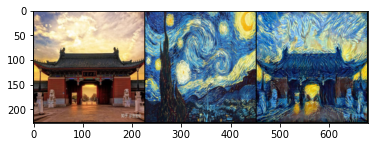

In [17]:
# 一般样本不可能只有一个，我们需要把他转化成网格输出
img = torchvision.utils.make_grid([content_img.squeeze(0),styple_img.squeeze(0),input_img.squeeze(0)])
# 其次，如果我们是在GPU上跑完的结果的话，我们需要再把结果带回cpu才能转化成numpy数组
# 但是我们通过上面的size可以知道我们的颜色通道宽高是不对劲的，于是我们需要转变他的维度，就是我们的tran
img = img.cpu().numpy().transpose(1,2,0)
plt.imshow(img)
plt.savefig("./output/"+content_name)
torch.save(new_model,"./model/style-0.00007-content-0.000006.pth")